<a id='head'></a>
# $Implementation Book &copy;\$  
`by Pasha and Dima`

# Оглавление

- [**1. Анализ данных**](#part_01)
    - [1.1 Hitmap для матрицы корреляции](#part_11)

    
- [**2. Подготовка к обучению**](#part_02)
    - [2.1 Разделение на выборки](#part_21)
    - [2.2 Standard Scaler](#part_22)
    - [2.3 One Hot Encoder](#part_23)
    - [2.4 Ordinal Encoder](#part_24)
    - [2.5 Pipeline](#part_25)

    
- [**3. Классификация**](#part_03)
    - [3.1 ](#part_31)


- [**4. Регрессия**](#part_04)
    - [4.1 ](#part_41)


- [**5. Тексты**](#part_05)
    - [5.1 ](#part_51)

    
- [**6. Зрение**](#part_06)
    - [6.1 ](#part_61)


- [**7. Обучение без учителя**](#part_07)
    - [7.1 ](#part_71)


---

<a id='part_01'></a>
# 1. Анализ данных [▴](#head)

<a id='part_11'></a>
## 1.1 Hitmap для матрицы корреляции [▴](#head)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = sns.load_dataset('tips')

Text(0.5, 1.0, 'Корреляционная матрица')

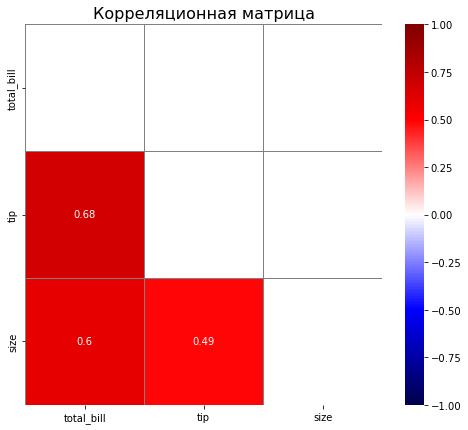

In [2]:
plt.figure(figsize=(8,7))
corr_matrix = sns.heatmap(df.corr(), # получаем матрицу корреляции
                          annot=True, # подписываем квадраты
                          vmin=-1, vmax=1, center=0, # определяем границы значений шкалы
                          cmap='seismic', # или coolwarm 
                          # https://matplotlib.org/stable/gallery/color/colormap_reference.html
                          mask=(np.tri(len(df.corr())).T), # создаем маску, чтобы отображать лишние блоки
                          linewidths=1,
                          linecolor='grey')

corr_matrix.set_title("Корреляционная матрица", fontsize=16)

# Маски:
# mask = np.triu(df.corr())
# mask = np.tril(df.corr())

---

<a id='part_02'></a>
# 2. Подготовка обучению[▴](#head)

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = sns.load_dataset('tips')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<a id='part_21'></a>
## 2.1 Разделение на выборки [▴](#head)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(['size'], axis=1)
y = df['size']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=12345, 
                                                    test_size=0.25,
                                                    stratify=y) # стратифицируем выборку по таргету
                                                                # чтобы в выборки попало одинаковое соотношение классов
                                                                # это требуется только для задач классификации

Размеры выборок:

(244, 7) - df
(244, 6) - X
(244,) - y


Доля: 0.75 | X: (183, 6) - Тренировочные
Доля: 0.75 | y: (183,) - Тренировочные

Доля: 0.25 | X: (61, 6) - Тестовые
Доля: 0.25 | y: (61,) - Тестовые


Распределение классов:


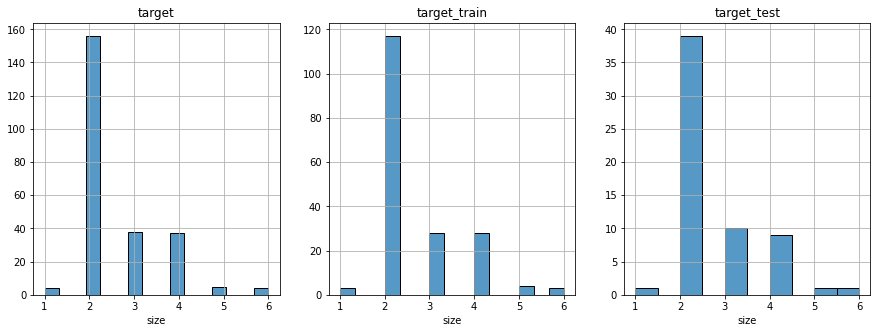

In [5]:
def part_of_df(X, y, title):
    print(f'\nДоля: {len(X) / len(df):.2f} | X: {X.shape} - {title}')
    print(f'Доля: {len(y) / len(df):.2f} | y: {y.shape} - {title}')

print('Размеры выборок:\n')

print(f'{df.shape} - df')
print(f'{X.shape} - X')
print(f'{y.shape} - y\n')

part_of_df(X_train, y_train, 'Тренировочные')
part_of_df(X_test, y_test, 'Тестовые')


print('\n')
print('Распределение классов:')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    sns.histplot(data=[y, y_train, y_test][i], ax=axs[i])
    axs[i].set_title(['target', 'target_train', 'target_test'][i])
    axs[i].grid()
    axs[i].set_ylabel('')
    
plt.show()

<a id='part_22'></a>
## 2.2 Standard Scaler [▴](#head)

Кодировать признаки стоит только после деления на выборки, иначе возможно утечка.

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=12345, 
                                                    test_size=0.25,
                                                    stratify=y)

### Обучаем Scaler

In [8]:
scaler = StandardScaler()

# получаем список заголовков столбцов с текстовыми данными
# получаем список заголовков столбцов с числовыми данными
cat_headings = X_train.select_dtypes(include=['object', 'category']).columns 
num_headings = X_train.columns.drop(cat_headings)

# оставим в переменных столбцы с числовыми и текстовыми даннымми
# и сбрасываем индекс для корректного конкатенирования
num_cols = X_train[num_headings].reset_index(drop=True) 
cat_cols = X_train[cat_headings].reset_index(drop=True)

scaler.fit(num_cols) # обучаем scaler

StandardScaler()

### Трансоформируем X_train

In [9]:
num_cols = scaler.transform(num_cols) # масштабируем признаки
# после преобразования получится numpy массив

# восстанавливаем датафрейм с цифровыми признаками
# только теперь они отмасштабированы
num_cols = pd.DataFrame(num_cols, columns=num_headings) 

In [10]:
# сшиваем обратно нашу тренировочную выборку
X_train = pd.concat([num_cols, cat_cols], axis=1).copy() 

In [11]:
X_train

,total_bill,tip,sex,smoker,day,time
0,-0.770112,-0.718032,Male,No,Sun,Dinner
1,-0.870775,-0.718032,Female,No,Thur,Lunch
2,3.302657,4.189135,Male,No,Sat,Dinner
3,-0.132585,-1.166688,Female,No,Thur,Lunch
4,2.108595,-0.017008,Male,Yes,Sat,Dinner
...,...,...,...,...,...,...
178,0.967757,-0.017008,Male,Yes,Sat,Dinner
179,-0.174238,0.684015,Male,No,Thur,Lunch
180,1.235033,-0.718032,Male,Yes,Sun,Dinner
181,1.069576,2.029981,Male,No,Sat,Dinner


### Трансоформируем X_test

In [12]:
cat_headings = X_test.select_dtypes(include=['object', 'category']).columns 
num_headings = X_test.columns.drop(cat_headings)

num_cols = X_test[num_headings].reset_index(drop=True) 
cat_cols = X_test[cat_headings].reset_index(drop=True)

num_cols = scaler.transform(num_cols)
num_cols = pd.DataFrame(num_cols, columns=num_headings)

X_test = pd.concat([num_cols, cat_cols], axis=1).copy()

In [13]:
X_test

,total_bill,tip,sex,smoker,day,time
0,-0.726145,-0.718032,Male,Yes,Thur,Lunch
1,1.517350,0.060104,Male,Yes,Sun,Dinner
2,-0.988792,-0.886278,Male,Yes,Sat,Dinner
3,-0.464655,-0.556797,Female,No,Sat,Dinner
4,-1.094083,-0.718032,Female,No,Thur,Lunch
...,...,...,...,...,...,...
56,-0.406803,-0.367520,Female,Yes,Fri,Lunch
57,-1.414582,-1.110606,Male,No,Thur,Lunch
58,-0.661351,-0.367520,Male,No,Sun,Dinner
59,-0.383662,0.144227,Female,Yes,Thur,Lunch


<a id='part_23'></a>
## 2.3 One Hot Encoder [▴](#head)

Кодировать признаки стоит только после деления на выборки, иначе возможно утечка.

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=12345, 
                                                    test_size=0.25,
                                                    stratify=y)

### Обучаем OHE

In [16]:
# чтобы модель не переобучилась избавляемся от первого признака в группе
ohe_encoder = OneHotEncoder(drop='first') 

# получаем список заголовков столбцов с текстовыми данными
# получаем список заголовков столбцов с числовыми данными
cat_headings = X_train.select_dtypes(include=['object', 'category']).columns 
num_headings = X_train.columns.drop(cat_headings)

# оставим в переменных столбцы с числовыми и текстовыми даннымми
# и сбрасываем индекс для корректного конкатенирования
num_cols = X_train[num_headings].reset_index(drop=True) 
cat_cols = X_train[cat_headings].reset_index(drop=True)

ohe_encoder.fit(cat_cols) # обучаем encoder

OneHotEncoder(drop='first')

### Трансоформируем X_train

In [17]:
# получаем массив кодированных признаков
cat_cols = ohe_encoder.transform(cat_cols).toarray() 

# получаем имена кодированных столбцов
new_headings = ohe_encoder.get_feature_names_out() 

# получаем датафрейм кодированных признаков с заголовками
cat_cols = pd.DataFrame(cat_cols, columns=new_headings)

In [18]:
# сшиваем обратно нашу тренировочную выборку
X_train = pd.concat([num_cols, cat_cols], axis=1).copy()

In [19]:
X_train

,total_bill,tip,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,13.13,2.00,1.0,0.0,0.0,1.0,0.0,0.0
1,12.26,2.00,0.0,0.0,0.0,0.0,1.0,1.0
2,48.33,9.00,1.0,0.0,1.0,0.0,0.0,0.0
3,18.64,1.36,0.0,0.0,0.0,0.0,1.0,1.0
4,38.01,3.00,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
178,28.15,3.00,1.0,1.0,1.0,0.0,0.0,0.0
179,18.28,4.00,1.0,0.0,0.0,0.0,1.0,1.0
180,30.46,2.00,1.0,1.0,0.0,1.0,0.0,0.0
181,29.03,5.92,1.0,0.0,1.0,0.0,0.0,0.0


### Трансоформируем X_test

In [20]:
cat_headings = X_test.select_dtypes(include=['object', 'category']).columns 
num_headings = X_test.columns.drop(cat_headings)

num_cols = X_test[num_headings].reset_index(drop=True) 
cat_cols = X_test[cat_headings].reset_index(drop=True)

cat_cols = ohe_encoder.transform(cat_cols).toarray() 
new_headings = ohe_encoder.get_feature_names_out() 
cat_cols = pd.DataFrame(cat_cols, columns=new_headings) 

X_test = pd.concat([num_cols, cat_cols], axis=1).copy()

In [21]:
X_test

,total_bill,tip,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,13.51,2.00,1.0,1.0,0.0,0.0,1.0,1.0
1,32.90,3.11,1.0,1.0,0.0,1.0,0.0,0.0
2,11.24,1.76,1.0,1.0,1.0,0.0,0.0,0.0
3,15.77,2.23,0.0,0.0,1.0,0.0,0.0,0.0
4,10.33,2.00,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
56,16.27,2.50,0.0,1.0,0.0,0.0,0.0,1.0
57,7.56,1.44,1.0,0.0,0.0,0.0,1.0,1.0
58,14.07,2.50,1.0,0.0,0.0,1.0,0.0,0.0
59,16.47,3.23,0.0,1.0,0.0,0.0,1.0,1.0


<a id='part_24'></a>
## 2.4 Ordinal Encoder [▴](#head)

Кодировать признаки стоит только после деления на выборки, иначе возможно утечка.

In [22]:
from sklearn.preprocessing import OrdinalEncoder

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=12345, 
                                                    test_size=0.25,
                                                    stratify=y)

### Обучаем Ordinal

In [24]:
ordinal_encoder = OrdinalEncoder()

# получаем список заголовков столбцов с текстовыми данными
# получаем список заголовков столбцов с числовыми данными
cat_headings = X_train.select_dtypes(include=['object', 'category']).columns 
num_headings = X_train.columns.drop(cat_headings)

# оставим в переменных столбцы с числовыми и текстовыми даннымми
# и сбрасываем индекс для корректного конкатенирования
num_cols = X_train[num_headings].reset_index(drop=True) 
cat_cols = X_train[cat_headings].reset_index(drop=True)

ordinal_encoder.fit(cat_cols) # обучаем encoder

OrdinalEncoder()

### Трансоформируем X_train

In [25]:
cat_cols = ordinal_encoder.transform(cat_cols) # масштабируем признаки
# после преобразования получится numpy массив

# восстанавливаем датафрейм с категориальными признаками
# только теперь они закодированы
cat_cols = pd.DataFrame(cat_cols, columns=cat_headings) 

In [26]:
# сшиваем обратно нашу тренировочную выборку
X_train = pd.concat([num_cols, cat_cols], axis=1).copy()

In [27]:
X_train

,total_bill,tip,sex,smoker,day,time
0,13.13,2.00,1.0,0.0,2.0,0.0
1,12.26,2.00,0.0,0.0,3.0,1.0
2,48.33,9.00,1.0,0.0,1.0,0.0
3,18.64,1.36,0.0,0.0,3.0,1.0
4,38.01,3.00,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...
178,28.15,3.00,1.0,1.0,1.0,0.0
179,18.28,4.00,1.0,0.0,3.0,1.0
180,30.46,2.00,1.0,1.0,2.0,0.0
181,29.03,5.92,1.0,0.0,1.0,0.0


### Трансоформируем X_test

In [28]:
cat_headings = X_test.select_dtypes(include=['object', 'category']).columns 
num_headings = X_test.columns.drop(cat_headings)

num_cols = X_test[num_headings].reset_index(drop=True) 
cat_cols = X_test[cat_headings].reset_index(drop=True)

cat_cols = ordinal_encoder.transform(cat_cols) # масштабируем признаки
cat_cols = pd.DataFrame(cat_cols, columns=cat_headings) 

X_test = pd.concat([num_cols, cat_cols], axis=1).copy()

In [29]:
X_test

,total_bill,tip,sex,smoker,day,time
0,13.51,2.00,1.0,1.0,3.0,1.0
1,32.90,3.11,1.0,1.0,2.0,0.0
2,11.24,1.76,1.0,1.0,1.0,0.0
3,15.77,2.23,0.0,0.0,1.0,0.0
4,10.33,2.00,0.0,0.0,3.0,1.0
...,...,...,...,...,...,...
56,16.27,2.50,0.0,1.0,0.0,1.0
57,7.56,1.44,1.0,0.0,3.0,1.0
58,14.07,2.50,1.0,0.0,2.0,0.0
59,16.47,3.23,0.0,1.0,3.0,1.0


<a id='part_25'></a>
## 2.5 Pipeline [▴](#head)

`Pipeline` нужен для оптимизации работы с подготовкой датасета к обучению и заброской в модель.

На него ложатся почти любые классы, которые имеют методы `.fit` `.transform` `.predict`

### Загрузка данных

Тут просто грузим датасет для примера

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/train.csv') # загружаем датасет
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'], errors='coerce') # в датасете есть ошибки правим их
df = df.dropna() # дропаем NaN

X = df.drop(['Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=12345, 
                                                    test_size=0.25,
                                                    stratify=y)
display(df.head())

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold # стратификация для работы в кросс-валидации

### Инициируем модель для пайплайна

Для пайплайна понадобится модель. Гиперпараметры можно указать сразу. 

Либо если `pipline` мы будем укладывать в `GridSearchCV`, то надо создать словарь с гиперпараметрами для модели.

In [32]:
# инициируем модель
# внутри модели гиперпараметры указываются как обычно
model = LogisticRegression(solver='liblinear', random_state=12345)

# создаем набор гиперпараметров для перебора в GridSearch
# перед гиперпараметром обязательно добавлять префикс: model__
# Этот префикс как имя указан в пайплайне и может быть любым, в данном примере именно model
params = {'model__class_weight': ['balanced', None],
          'model__C': [0.1, 0.5, 1, 1.5, 2, 5, 10, 50, 100]}

### Формируем пайплайны и GridSearch

Так как мы используем два кодировщика, их работу надо объединить перед тем как помещать в `pipeline`, для этого существует класс `ColumnTransformer` в библиотеке `sklearn`

In [33]:
# получаем список заголовков для текстовых и числовых столбцов (любым образом)
cat_headings = X_train.select_dtypes(include=['object', 'category']).columns 
num_headings = X_train.columns.drop(cat_headings)

# инициируем Скалер и Кодировщик
scaler = StandardScaler()             # масштабирование признаков
encoder = OneHotEncoder(drop="first") # кодирование текстовых признаков
# encoder = OrdinalEncoder()

# инициируем класс ColumnTransformer для объединения
# работы Стандарт Скалера и Кодировщика
col_transformer = ColumnTransformer([("num", scaler, num_headings),   # ([(имя, трансформер, список заголовков),
                                     ("cat", encoder, cat_headings)]) #   (имя, трансформер, список заголовков)])

# инициируем пайплайн
pipe = Pipeline([("transformer", col_transformer), # ([(имя, трансформер),
                 ("model", model)])                #   (имя, модель)])

# инициируем класс для стратификации в GridSearch
skf = StratifiedKFold(n_splits=5)   # стратификация выборок при кроссвалидации 
                                    # (нужно только в задачах классификации)

# инициируем ГридСерч с пайплайном
gs = GridSearchCV(estimator=pipe,    # вместо модели указываем наш папйплайн
                  param_grid=params, # параметры, тут все стандратно
                  cv=skf, # количество фолдов в кросс валидации, 
                          # при классификации пользуемся StratifiedKFold(n_splits=)
                          # чтобы выборки были стратифицированны
                          # при регрессии просто ставим число
                  scoring='roc_auc', # оценщик
                  n_jobs=-1) # активируем все потоки и процессоры при расчетах

### Обучаем GridSearch с пайплайном

In [34]:
%%time
gs.fit(X_train, y_train)
print('Обучено')

Обучено
CPU times: total: 594 ms
Wall time: 3.43 s


### Собираем результаты

In [35]:
best_pipe = gs.best_estimator_ # лучший пайплайн

best_trans = gs.best_estimator_[0] # трансформер, для конвертации тестовой выборки
best_model = gs.best_estimator_[1] # модель с лучшими гиперпараметрами
best_score = gs.best_score_        # лучши результат, который дала лучшая модель
best_params = gs.best_params_      # гиперпараметры модели, которая дала лучший результат

In [37]:
print(best_model)
print(best_score)
print(best_params)

LogisticRegression(C=5, random_state=12345, solver='liblinear')
0.8412584399632367
{'model__C': 5, 'model__class_weight': None}


Если нужно достать заголовки трансформированной выборки с помощью `OneHotEncoder` то применить:

In [36]:
# transformed_headings = best_trans.get_feature_names_out()

### Обучаем полученный пайплайн с лучшей моделью

Через трансформеры и модель так же можно прогнать по отдельности. Просто это 2 операции вместо одной.

In [38]:
best_pipe.fit(X_train, y_train)
print('Обучено')

Обучено


### Работаем с обученным пайплайном

In [39]:
predicted = best_pipe.predict(X_test)
proba = best_pipe.predict_proba(X_test)[:, 1]

print('Предсказания:', predicted)
print('Вероятности:', proba)
print('ROC AUC:', roc_auc_score(y_test, proba))
print('accuracy:', accuracy_score(y_test, predicted))

Предсказания: [0 0 0 ... 1 0 0]
Вероятности: [0.05473805 0.30493068 0.04417681 ... 0.68386038 0.34710905 0.00640595]
ROC AUC: 0.8498773235746662
accuracy: 0.8119787717968158


---

<a id='part_03'></a>
# 3. Классификация [▴](#head)

<a id='part_31'></a>
## 3.1 [▴](#head)

---

<a id='part_04'></a>
# 4. Регрессия [▴](#head)

<a id='part_41'></a>
## 4.1 [▴](#head)

---

<a id='part_05'></a>
# 5. Тексты [▴](#head)

<a id='part_51'></a>
## 5.1 [▴](#head)

Рекурентные нейронные сети умеют хорошо генерировать тексты, мат. формулы, а так же программный код

---

<a id='part_06'></a>
# 6. Зрение [▴](#head)

<a id='part_61'></a>
## 6.1 [▴](#head)

---

<a id='part_07'></a>
# 7. Обучение без учителя [▴](#head)

<a id='part_71'></a>
## 7.1 [▴](#head)

---